# **Generative AI (CS F437) Project Task 2**

Team Members
1.   Deepan Roy - 2022A7PS0004P
2.   Akshay Shukla - 2022A7PS0087P



In [ ]:
#importing the necessary libraries
import argparse
import os
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
from torch.autograd import Function

import torch.nn as nn
import torch.nn.functional as F
import torch

In [ ]:
#configurations and hyperparameters for the model
n_epochs = 20
batch_size = 32
lr = 0.001
b1 = 0.5
b2 = 0.999
n_cpu = 1
latent_dim = 32
img_size = 28
channels = 1
sample_interval = 400

In [3]:
img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False

In [ ]:
#architecture for the encoder used. We have used multiple Convolutional blocks because we are dealing with an image dataset. This helps in extracting heirarchial features and mapping it to a latent space
class ContentStyleEncoder(nn.Module):
    def __init__(self):
        super(ContentStyleEncoder, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten()
        )

        self.mu_content = nn.Linear(1152, latent_dim)
        self.logvar_content = nn.Linear(1152, latent_dim)
        self.mu_style = nn.Linear(1152, latent_dim)
        self.logvar_style = nn.Linear(1152, latent_dim)

    def reparameterization(self, mu, logvar):  #function to implement the reparameterisation trick
        std = torch.exp(logvar / 2)
        sampled_z = Variable(Tensor(np.random.normal(0, 1, (mu.size(0), latent_dim))))
        z = sampled_z * std + mu
        return z

    def forward(self, img):
        # img_flat = img.view(img.shape[0], -1)
        x = self.model(img)
        # print(x.shape)
        mu_content = self.mu_content(x)
        logvar_content = self.logvar_content(x)
        mu_style = self.mu_style(x)
        logvar_style = self.logvar_style(x)
        z_content = self.reparameterization(mu_content, logvar_content)
        z_style = self.reparameterization(mu_style, logvar_style)
        return z_content, z_style

In [ ]:
#architecture for the decoder used. The multiple transpose convolutional blocks implemented help in generating new images using the features it obtains from the latent space distribution
class ContentStyleDecoder(nn.Module):
    def __init__(self):
        super(ContentStyleDecoder, self).__init__()

        self.fc = nn.Linear(2 * latent_dim, 128 * 4 * 4)  # Project latent to feature map

        self.net = nn.Sequential(
            nn.BatchNorm1d(128 * 4 * 4),
            nn.Unflatten(1, (128, 4, 4)),          # Shape: (B, 128, 4, 4)

            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 4→8
            nn.BatchNorm2d(64), nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # 8→16
            nn.BatchNorm2d(32), nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(32, 16, 4, 2, 1),   # 16→32
            nn.BatchNorm2d(16), nn.LeakyReLU(0.2),

            nn.Conv2d(16, 1, kernel_size=5, padding=0),  # Bring down to 1 channel
            nn.Sigmoid(),  # Output in [0,1]
        )

    def forward(self, z_content, z_style):
        z = torch.cat([z_content, z_style], dim=1)
        img_flat = self.fc(z)
        img = self.net(img_flat)
        # img = img_flat.view(img_flat.shape[0], *img_shape)
        return img

In [ ]:
#defining the discriminator architecture.
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        validity = self.model(z)
        return validity

In [7]:
class ContentClassifier(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, z_content):
        return self.fc(z_content)   # logits over classes

In [8]:
class GradReverse(Function):
    @staticmethod
    def forward(ctx, x, lam):
        ctx.lambda_ = lam
        return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambda_, None

def grad_reverse(x, lam=1.0):
    return GradReverse.apply(x, lam)

class StyleClassifier(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, z_style, lam=1.0):
        # apply GRL so encoder sees reversed gradient
        z_style_rev = grad_reverse(z_style, lam)
        return self.fc(z_style_rev)   # logits over classes

In [9]:
#loading the Omniglot dataset. The images are resized and converted into Gray scale
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

dataset = datasets.Omniglot(root='./data', background=True, download=True, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Use binary cross-entropy loss
adversarial_loss = torch.nn.BCELoss()
pixelwise_loss = torch.nn.L1Loss()
content_classifier_loss = torch.nn.BCEWithLogitsLoss()
style_classifier_loss = torch.nn.BCEWithLogitsLoss()

# Initialize generator and discriminator
encoder = ContentStyleEncoder()
decoder = ContentStyleDecoder()
discriminator_content = Discriminator()
discriminator_style = Discriminator()
content_classifier = ContentClassifier(latent_dim, 1623)
style_classifier = StyleClassifier(latent_dim, 1623)

if cuda:
    encoder.cuda()
    decoder.cuda()
    discriminator_content.cuda()
    discriminator_style.cuda()
    adversarial_loss.cuda()
    pixelwise_loss.cuda()
    content_classifier.cuda()
    style_classifier.cuda()

# Optimizers
optimiser_G = torch.optim.Adam(
    itertools.chain(encoder.parameters(), decoder.parameters()), lr=lr, betas=(b1, b2)
)
optimiser_D_content = torch.optim.Adam(discriminator_content.parameters(), lr=lr, betas=(b1, b2))
optimiser_D_style = torch.optim.Adam(discriminator_style.parameters(), lr=lr, betas=(b1, b2))

optimiser_content_classifier = torch.optim.Adam(content_classifier.parameters(), lr=lr, betas=(b1, b2))
optimiser_style_classifier = torch.optim.Adam(style_classifier.parameters(), lr=lr, betas=(b1, b2))

scheduler_G = torch.optim.lr_scheduler.OneCycleLR(
    optimiser_G, max_lr=1e-4, total_steps=n_epochs*len(train_dataloader),
    pct_start=0.1, anneal_strategy='cos', div_factor=10)
scheduler_D_content = torch.optim.lr_scheduler.OneCycleLR(
    optimiser_D_content, max_lr=1e-4, total_steps=n_epochs*len(train_dataloader),
    pct_start=0.1, anneal_strategy='cos', div_factor=10)
scheduler_D_style = torch.optim.lr_scheduler.OneCycleLR(
    optimiser_D_style, max_lr=1e-4, total_steps=n_epochs*len(train_dataloader),
    pct_start=0.1, anneal_strategy='cos', div_factor=10)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

#Training loop

for epoch in range(n_epochs):
    for imgs, labels in tqdm(train_dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))
        labels = Variable(labels.type(Tensor))
        labels = F.one_hot(labels.to(torch.int64), num_classes=1623).float().to(device)

        #Training the Discriminator
        optimiser_D_content.zero_grad()
        optimiser_D_style.zero_grad()

        # Sample noise as discriminator ground truth
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
        z_content, z_style = encoder(real_imgs)

        # Measure discriminator's ability to classify real from generated samples
        real_loss_content = adversarial_loss(discriminator_content(z), valid)
        fake_loss_content = adversarial_loss(discriminator_content(z_content.detach()), fake)
        d_loss_content = 0.5 * (real_loss_content + fake_loss_content)

        real_loss_style = adversarial_loss(discriminator_style(z), valid)
        fake_loss_style = adversarial_loss(discriminator_style(z_style.detach()), fake)
        d_loss_style = 0.5 * (real_loss_style + fake_loss_style)

        d_loss_content.backward()
        d_loss_style.backward()
        optimiser_D_content.step()
        optimiser_D_style.step()

        # Training the Content and Style Classifiers
        z_content, z_style = encoder(real_imgs)

        optimiser_content_classifier.zero_grad()
        logits_content = content_classifier(z_content)
        content_loss = content_classifier_loss(logits_content, labels)
        content_loss.backward()
        optimiser_content_classifier.step()

        z_content, z_style = encoder(real_imgs)

        optimiser_style_classifier.zero_grad()
        logits_style = style_classifier(z_style)
        style_loss = style_classifier_loss(logits_style, labels)
        style_loss.backward()
        optimiser_style_classifier.step()

        # Training the Generator

        optimiser_G.zero_grad()

        z_content, z_style = encoder(real_imgs)
        decoded_imgs = decoder(z_content, z_style)

        # Loss measures generator's ability to fool the discriminator
        g_loss = 0.98 * pixelwise_loss(decoded_imgs, real_imgs) \
                + 0.005 * adversarial_loss(discriminator_content(z_content), valid) \
                + 0.005 * adversarial_loss(discriminator_style(z_style), valid) \
                + 0.005 * content_classifier_loss(content_classifier(z_content), labels) \
                + 0.005 * style_classifier_loss(style_classifier(z_style), labels)

        g_loss.backward()
        optimiser_G.step()
    
    scheduler_G.step()
    scheduler_D_content.step()
    scheduler_D_style.step()

    print(f"[Epoch {epoch}/{n_epochs}] [D content loss: {d_loss_content.item()}] [D style loss: {d_loss_style.item()}] [G loss: {g_loss.item()}]", end=" ")
    print(f"[Content classifier loss: {content_loss}] [Style classifier loss: {style_loss}]")

100%|██████████| 482/482 [00:21<00:00, 22.28it/s]


[Epoch 0/20] [D content loss: 0.7227197885513306] [D style loss: 0.688163161277771] [G loss: 0.2981027066707611] [Content classifier loss: 0.006444362923502922] [Style classifier loss: 0.0065211826004087925]


100%|██████████| 482/482 [00:10<00:00, 45.21it/s]


[Epoch 1/20] [D content loss: 0.7106934785842896] [D style loss: 0.703374981880188] [G loss: 0.19060422480106354] [Content classifier loss: 0.005249129142612219] [Style classifier loss: 0.005362133961170912]


100%|██████████| 482/482 [00:23<00:00, 20.35it/s]


[Epoch 2/20] [D content loss: 0.6809903383255005] [D style loss: 0.6835352182388306] [G loss: 0.13144464790821075] [Content classifier loss: 0.004968933295458555] [Style classifier loss: 0.004937268327921629]


100%|██████████| 482/482 [00:20<00:00, 23.31it/s]


[Epoch 3/20] [D content loss: 0.6851075887680054] [D style loss: 0.6414738893508911] [G loss: 0.10588330775499344] [Content classifier loss: 0.004613019060343504] [Style classifier loss: 0.004686132073402405]


100%|██████████| 482/482 [00:10<00:00, 46.16it/s]


[Epoch 4/20] [D content loss: 0.66560298204422] [D style loss: 0.6056512594223022] [G loss: 0.092811219394207] [Content classifier loss: 0.004498301073908806] [Style classifier loss: 0.004426290281116962]


100%|██████████| 482/482 [00:14<00:00, 32.92it/s]


[Epoch 5/20] [D content loss: 0.6342999935150146] [D style loss: 0.5793946981430054] [G loss: 0.075531966984272] [Content classifier loss: 0.004054324235767126] [Style classifier loss: 0.004046175163239241]


100%|██████████| 482/482 [00:32<00:00, 14.76it/s]


[Epoch 6/20] [D content loss: 0.6734119057655334] [D style loss: 0.6660071611404419] [G loss: 0.07080676406621933] [Content classifier loss: 0.003924595192074776] [Style classifier loss: 0.0036920339334756136]


100%|██████████| 482/482 [00:32<00:00, 14.65it/s]


[Epoch 7/20] [D content loss: 0.6259217262268066] [D style loss: 0.6168258786201477] [G loss: 0.06956566125154495] [Content classifier loss: 0.003607629332691431] [Style classifier loss: 0.0034208460710942745]


100%|██████████| 482/482 [00:32<00:00, 14.68it/s]


[Epoch 8/20] [D content loss: 0.6270598769187927] [D style loss: 0.6907585263252258] [G loss: 0.06833011656999588] [Content classifier loss: 0.003684861119836569] [Style classifier loss: 0.0036107636988162994]


100%|██████████| 482/482 [00:32<00:00, 14.66it/s]


[Epoch 9/20] [D content loss: 0.6789278984069824] [D style loss: 0.6818469762802124] [G loss: 0.05710828676819801] [Content classifier loss: 0.0035254922695457935] [Style classifier loss: 0.003550683381035924]


100%|██████████| 482/482 [00:32<00:00, 14.63it/s]


[Epoch 10/20] [D content loss: 0.6948097944259644] [D style loss: 0.6445143222808838] [G loss: 0.052540622651576996] [Content classifier loss: 0.003352182451635599] [Style classifier loss: 0.0033350090961903334]


100%|██████████| 482/482 [00:32<00:00, 14.64it/s]


[Epoch 11/20] [D content loss: 0.6687277555465698] [D style loss: 0.7082517147064209] [G loss: 0.05055771768093109] [Content classifier loss: 0.0028677594382315874] [Style classifier loss: 0.0028311675414443016]


100%|██████████| 482/482 [00:32<00:00, 14.66it/s]


[Epoch 12/20] [D content loss: 0.652450442314148] [D style loss: 0.6346447467803955] [G loss: 0.05106143280863762] [Content classifier loss: 0.0032219686545431614] [Style classifier loss: 0.0030334575567394495]


100%|██████████| 482/482 [00:32<00:00, 14.62it/s]


[Epoch 13/20] [D content loss: 0.7264916896820068] [D style loss: 0.6962056159973145] [G loss: 0.048073526471853256] [Content classifier loss: 0.0032272564712911844] [Style classifier loss: 0.002878838684409857]


100%|██████████| 482/482 [00:33<00:00, 14.58it/s]


[Epoch 14/20] [D content loss: 0.6882625818252563] [D style loss: 0.6773239374160767] [G loss: 0.04357476159930229] [Content classifier loss: 0.0026790527626872063] [Style classifier loss: 0.002481889445334673]


100%|██████████| 482/482 [00:32<00:00, 14.62it/s]


[Epoch 15/20] [D content loss: 0.7635159492492676] [D style loss: 0.7033588886260986] [G loss: 0.04194636270403862] [Content classifier loss: 0.0027373807970434427] [Style classifier loss: 0.0026263119652867317]


100%|██████████| 482/482 [00:32<00:00, 14.66it/s]


[Epoch 16/20] [D content loss: 0.6837389469146729] [D style loss: 0.7150797843933105] [G loss: 0.04440804943442345] [Content classifier loss: 0.002348675625398755] [Style classifier loss: 0.002499439986422658]


100%|██████████| 482/482 [00:33<00:00, 14.59it/s]


[Epoch 17/20] [D content loss: 0.6868959069252014] [D style loss: 0.684509813785553] [G loss: 0.04200899600982666] [Content classifier loss: 0.002981957048177719] [Style classifier loss: 0.0024829229805618525]


100%|██████████| 482/482 [00:23<00:00, 20.78it/s]


[Epoch 18/20] [D content loss: 0.689155101776123] [D style loss: 0.6647602319717407] [G loss: 0.03835994750261307] [Content classifier loss: 0.0024712192825973034] [Style classifier loss: 0.0028169790748506784]


100%|██████████| 482/482 [00:10<00:00, 46.81it/s]

[Epoch 19/20] [D content loss: 0.640738308429718] [D style loss: 0.7010750770568848] [G loss: 0.0391547791659832] [Content classifier loss: 0.0028342395089566708] [Style classifier loss: 0.0025503148790448904]


In [12]:
torch.save(encoder.state_dict(), "aae_encoder_cs_v6.pth")
torch.save(decoder.state_dict(), "aae_decoder_cs_v6.pth")
torch.save(discriminator_content.state_dict(), "aae_discriminator_content_v6.pth")
torch.save(discriminator_style.state_dict(), "aae_discriminator_style_v6.pth")
torch.save(content_classifier.state_dict(), "aae_content_classifier_v6.pth")
torch.save(style_classifier.state_dict(), "aae_style_classifier_v6.pth")

In [13]:
def sample_image(n_row, batches_done):
    """Saves a grid of generated digits"""
    # Sample noise
    z_content = Variable(Tensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
    z_style = Variable(Tensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
    gen_imgs = decoder(z_content, z_style)
    save_image(gen_imgs.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)

In [ ]:
sample_image(n_row=10, batches_done=0)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

#random sampling from prior
def generate_random(n=8):
    z_content = torch.randn(n, latent_dim).to(device)
    z_style = torch.randn(n, latent_dim).to(device)
    # z_s = torch.randn(n, latent_dim).to(device)
    with torch.no_grad():
        x_gen = decoder(z_content, z_style).cpu()
    return x_gen

# style transfer
def style_content_mixing():
    batch = next(iter(test_dataloader))[0][:2].to(device)
    content_img, style_img = batch[0].unsqueeze(0), batch[1].unsqueeze(0)
    with torch.no_grad():
        z_content, _ = encoder(content_img)
        _, z_style = encoder(style_img)
        mix = decoder(z_content, z_style).cpu()

    fig, axes = plt.subplots(1, 3, figsize=(8, 3))
    for ax, img, title in zip(axes, [content_img, style_img, mix], ["Content", "Style", "Generated"]):
        ax.imshow(img.squeeze().cpu(), cmap="gray")
        ax.set_title(title)
        ax.axis("off")
    plt.show()

#interpolation between two images
def interpolate_latent(n_steps=8):
    imgs = next(iter(test_dataloader))[0][:2].to(device)
    with torch.no_grad():
        z_content_1, z_style_1 = encoder(imgs[0].unsqueeze(0))
        z_content_2, z_style_2 = encoder(imgs[1].unsqueeze(0))
        # Create a range of values between 0 and 1 for interpolation
        t_values = torch.linspace(0, 1, n_steps, device=device) #move t_values to device
        # Interpolate latent codes for content and style using reshape and repeat
        z_content_interp = z_content_1.reshape(1, -1).repeat(n_steps, 1) * (1 - t_values.reshape(-1, 1)) + z_content_2.reshape(1, -1).repeat(n_steps, 1) * t_values.reshape(-1, 1)
        z_style_interp = z_style_1.reshape(1, -1).repeat(n_steps, 1) * (1 - t_values.reshape(-1, 1)) + z_style_2.reshape(1, -1).repeat(n_steps, 1) * t_values.reshape(-1, 1)
        gen = decoder(z_content_interp, z_style_interp).cpu()

    fig, axes = plt.subplots(1, n_steps, figsize=(20, 2))
    for i in range(n_steps):
        axes[i].imshow(gen[i].squeeze(), cmap="gray")
        axes[i].axis("off")
    plt.suptitle("Latent Interpolation")
    plt.show()

Random Sampling


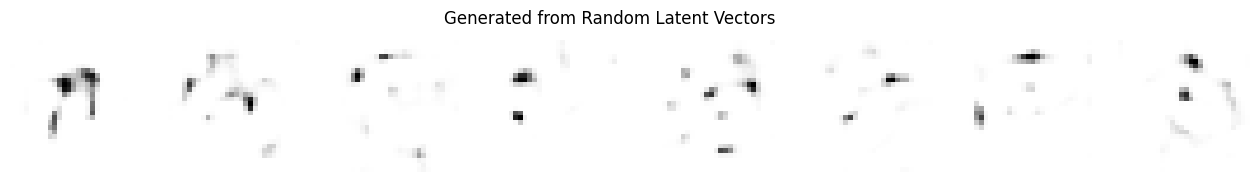

Style-Content Mixing


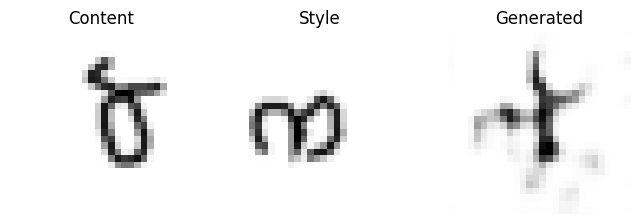

Latent Interpolation


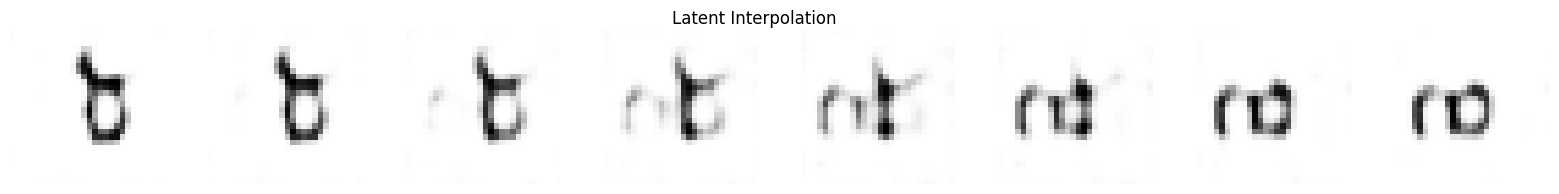

Content KL Divergence: 3.8717433460487807
Style KL Divergence: 3.2621645769797083


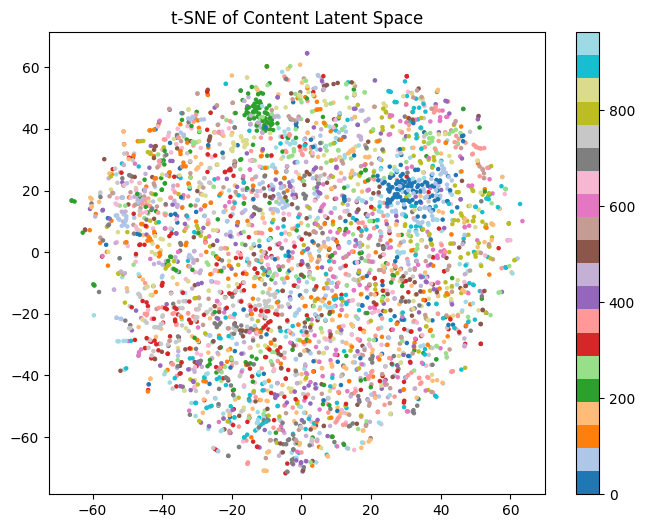

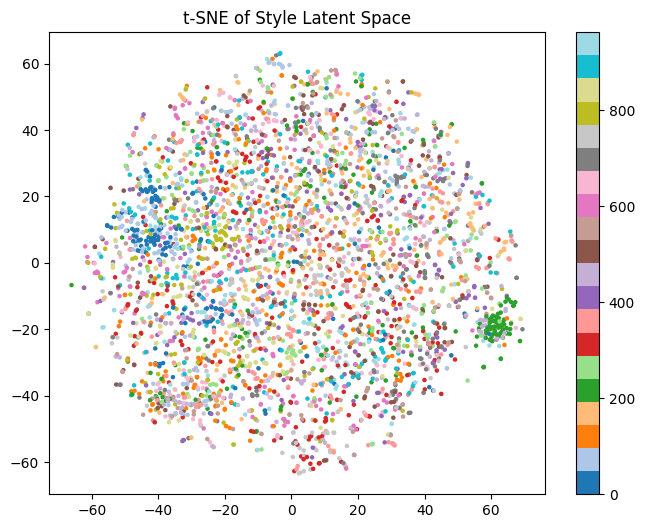

Content Clustering Accuracy: 0.0045186721991701245
Style Clustering Accuracy: 0.0042966804979253112


In [ ]:
encoder.eval()
decoder.eval()

#generating new images by learning the content and style features from the latent space
print("Random Sampling")
generated = generate_random(8)
fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i, ax in enumerate(axes):
    ax.imshow(generated[i].squeeze(), cmap="gray")
    ax.axis("off")
plt.suptitle("Generated from Random Latent Vectors")
plt.show()

print("Style-Content Mixing")
style_content_mixing()

print("Latent Interpolation")
interpolate_latent()

def kl_divergence(z):
    return -0.5 * torch.sum(1 - z.pow(2) - torch.log(torch.ones_like(z))) / z.size(0)

latents_content = []
latents_style = []
labels = []
images = []
kl_losses_content = []
kl_losses_style = []
with torch.no_grad():
    for data, label in test_dataloader:
        data = data.to(device)
        z_content, z_style = encoder(data)
        latents_content.append(z_content.cpu())
        latents_style.append(z_style.cpu())
        images.append(data.cpu())
        labels.extend(label.numpy())
        kl_losses_content.append(kl_divergence(z_content).cpu().item())
        kl_losses_style.append(kl_divergence(z_style).cpu().item())

latents_content = torch.cat(latents_content).numpy()
latents_style = torch.cat(latents_style).numpy()
labels = np.array(labels)
images = torch.cat(images)

print(f"Content KL Divergence: {np.mean(kl_losses_content)}")
print(f"Style KL Divergence: {np.mean(kl_losses_style)}")

# t-SNE
tsne_content = TSNE(n_components=2, random_state=42)
tsne_latents_content = tsne_content.fit_transform(latents_content)
plt.figure(figsize=(8, 6))
plt.scatter(tsne_latents_content[:, 0], tsne_latents_content[:, 1], c=labels, cmap='tab20', s=5)
plt.title('t-SNE of Content Latent Space')
plt.colorbar()
plt.show()

tsne_style = TSNE(n_components=2, random_state=42)
tsne_latents_style = tsne_style.fit_transform(latents_style)
plt.figure(figsize=(8, 6))
plt.scatter(tsne_latents_style[:, 0], tsne_latents_style[:, 1], c=labels, cmap='tab20', s=5)
plt.title('t-SNE of Style Latent Space')
plt.colorbar()
plt.show()

# Clustering Accuracy
kmeans_content = KMeans(n_clusters=len(np.unique(labels)), random_state=42).fit(latents_content)
clustering_accuracy = accuracy_score(labels, kmeans_content.labels_)
print(f"Content Clustering Accuracy: {clustering_accuracy}")

kmeans_style = KMeans(n_clusters=len(np.unique(labels)), random_state=42).fit(latents_style)
clustering_accuracy = accuracy_score(labels, kmeans_style.labels_)
print(f"Style Clustering Accuracy: {clustering_accuracy}")